In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.metrics import roc_curve, auc
%matplotlib inline


In [3]:
train_df = pd.read_csv('/Users/Jeff/downloads/all/train.csv')
spray_df = pd.read_csv('/Users/Jeff/downloads/all/spray.csv')

In [147]:
print(train_df.isnull().sum())

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64


In [5]:
# creating neg and positive set, so data is evenly distributed and not skewed

neg_set_df = train_df[train_df.WnvPresent == 0]
pos_set_df = train_df[train_df.WnvPresent == 1]

In [6]:
neg_set_df = neg_set_df.sample(pos_set_df.shape[0])

In [7]:
new_train = pd.concat([pos_set_df, neg_set_df])

In [8]:
# new_train.

In [9]:
# need to create features with new DataFrame

In [10]:
wnv_means = new_train.groupby('Species').WnvPresent.mean().reset_index()
wnv_means.columns = ['Species','wnv_species']
train_w_species = new_train.merge(wnv_means, how="left", on="Species")

# this will add average of WNV present per species

In [11]:
# train_w_species.head(1)

In [12]:
wnv_means_block = new_train.groupby('Block').WnvPresent.mean().reset_index()
wnv_means_block.columns = ['Block','wnv_means_block']
train_w_block = train_w_species.merge(wnv_means_block, how="left", on="Block")

In [13]:
# would really like to get a binary field for if pesticide was sprayed at this lat long

In [14]:
train_w_block['ll_location'] = round(train_w_block['Latitude'], 3).astype(str) + '|' + round(train_w_block['Longitude'], 3).astype(str)
spray_df['ll_location'] = round(spray_df['Latitude'], 3).astype(str) + '|' + round(spray_df['Longitude'], 3).astype(str)

In [15]:
# always want my was_sprayed field to be 1 in my spray dataset
spray_df['was_sprayed'] = 1

In [16]:
# merging spray data back onto set
train_w_spray = train_w_block.merge(spray_df[['ll_location', 'was_sprayed']], how="left", on="ll_location")

In [17]:
# train_w_spray.head(1)

In [18]:
# now I need to convert my 'was_sprayed' field to binary

In [19]:
train_w_spray['was_sprayed'] = train_w_spray.was_sprayed.fillna(0).astype('int')

In [20]:
# train_w_spray.head(1)

In [21]:
train_w_spray['Date'] = pd.to_datetime(train_w_spray.Date)

In [22]:
train_w_spray['month'] = train_w_spray.Date.dt.month

In [24]:
full_data_set = train_w_spray.groupby('month').WnvPresent.mean().reset_index()
full_data_set.columns = ['month','wnv_means_month']
full_w_months = train_w_spray.merge(full_data_set, how="left", on="month")

In [26]:
full_w_months.head(1)
full_w_months.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'wnv_species', 'wnv_means_block',
       'll_location', 'was_sprayed', 'month', 'wnv_means_month'],
      dtype='object')

In [44]:
columns_trial_1 = ['NumMosquitos', 'wnv_species', 'wnv_means_block', 'was_sprayed', 'wnv_means_month', 'WnvPresent']

In [31]:
first_trial_df = full_w_months[columns_trial_1]

In [150]:
# first_trial_df.head(25)

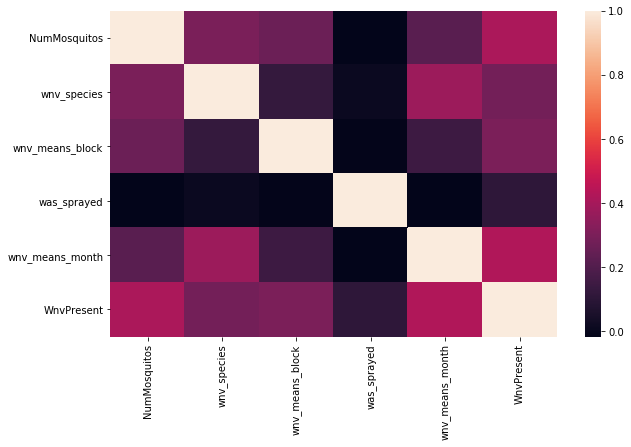

In [151]:
fig, ax = plt.subplots(figsize=(10,6))   
ft_corr = first_trial_df.corr()
sns.heatmap(ft_corr, 
        xticklabels=ft_corr.columns,
        yticklabels=ft_corr.columns,
        ax=ax)
# was_sprayed doesn't seem very strong...

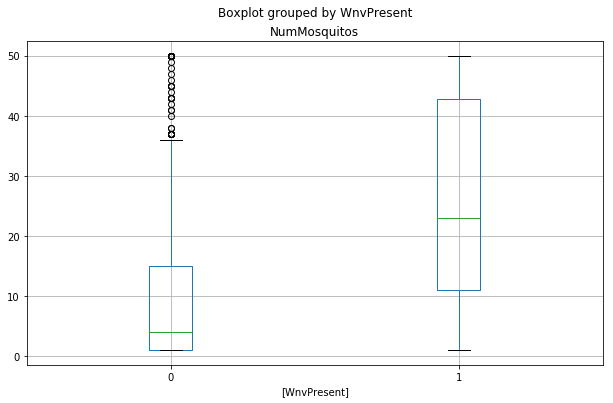

In [39]:
first_trial_df[['NumMosquitos', 'WnvPresent']].boxplot(by='WnvPresent', figsize=(10,6))

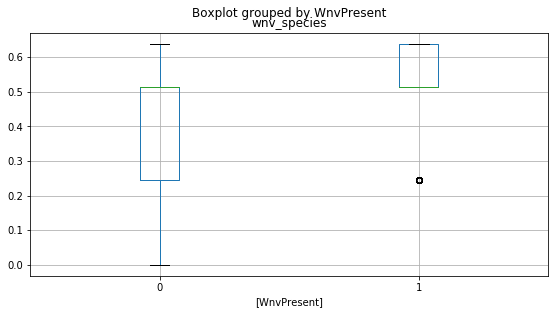

In [154]:
first_trial_df[['wnv_species', 'WnvPresent']].boxplot(by='WnvPresent', figsize=(9,4.5))

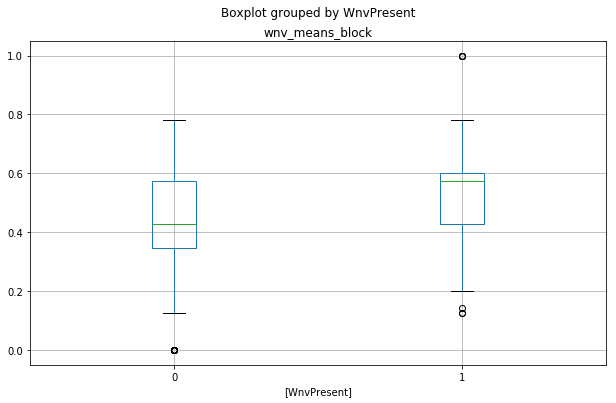

In [41]:
first_trial_df[['wnv_means_block', 'WnvPresent']].boxplot(by='WnvPresent', figsize=(10,6))

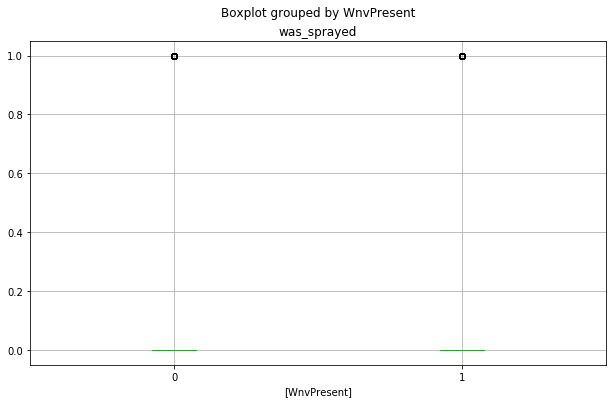

In [42]:
first_trial_df[['was_sprayed', 'WnvPresent']].boxplot(by='WnvPresent', figsize=(10,6))

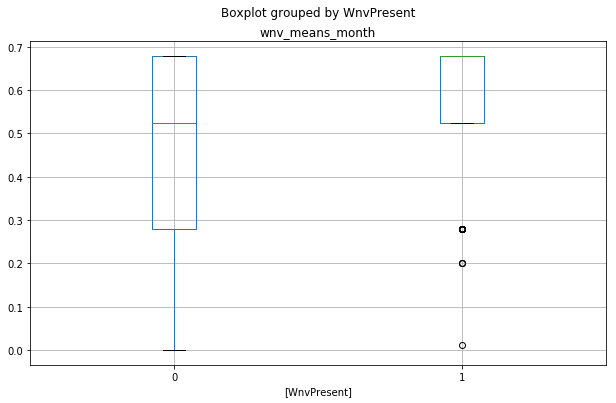

In [43]:
first_trial_df[['wnv_means_month', 'WnvPresent']].boxplot(by='WnvPresent', figsize=(10,6))

In [ ]:
# was_sprayed seems pretty weak so let's remove that

In [46]:
columns_trial_2 = ['NumMosquitos', 'wnv_species', 'wnv_means_block', 'wnv_means_month', 'WnvPresent']
second_trial_df = full_w_months[columns_trial_2]

In [47]:
features_for_training = ['NumMosquitos', 'wnv_species', 'wnv_means_block', 'wnv_means_month']

In [50]:
# train a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logreg = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(
    full_w_months[features_for_training],full_w_months.WnvPresent, test_size = 0.1)

logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
logreg.score(X_test, y_test)

0.7479674796747967

In [57]:
y_test.value_counts()

1    67
0    56
Name: WnvPresent, dtype: int64

In [ ]:
# Null model would be just guessing WNV not present every time. In these data sets I would have only been right 56/123
# times -> Null model accuracy score of 0.4552845528 -> ~46%

In [67]:
test_pred_probs = logreg.predict_proba(X_test)[:, 1]

In [70]:
plot_df = pd.DataFrame({'pred': test_pred_probs, 'actual': y_test})

In [76]:
plot_df['qcut_pred_proba'] = pd.qcut(test_pred_probs, q=10)

In [77]:
# plot_df.head()

In [79]:
summary_df = plot_df.groupby('qcut_pred_proba').actual.mean().reset_index()

In [84]:
summary_df.head()

,qcut_pred_proba,actual
0,"(0.036199999999999996, 0.203]",0.000000
1,"(0.203, 0.318]",0.333333
2,"(0.318, 0.372]",0.333333
3,"(0.372, 0.455]",0.416667
4,"(0.455, 0.516]",0.461538


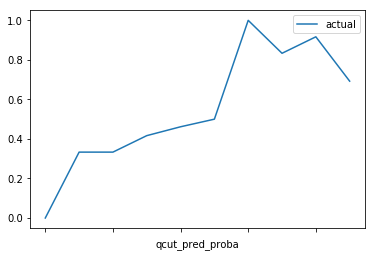

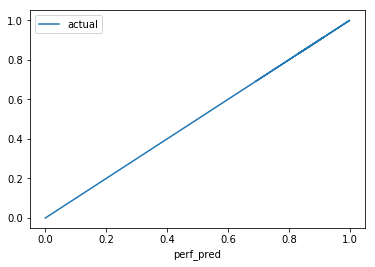

In [156]:
pred_plot = summary_df.plot(kind='line', x='qcut_pred_proba', y='actual')
summary_df['perf_pred'] = summary_df['actual']
perfect_plot = summary_df.plot(kind='line', x='perf_pred', y='actual')

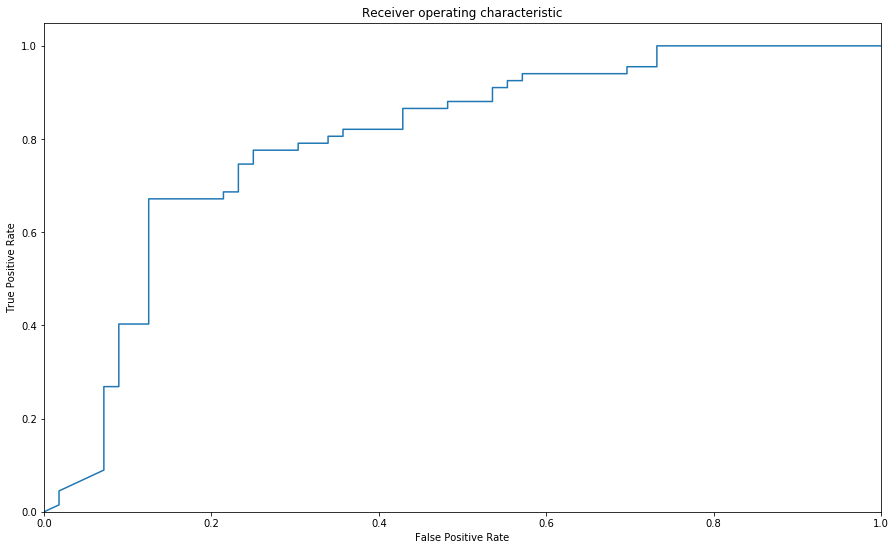

In [145]:
# false positive rate
fpr = dict()

# true positive rate
tpr = dict()

#AUC = area under curve
roc_auc = dict()


for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, test_pred_probs)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(15,9))
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.show()

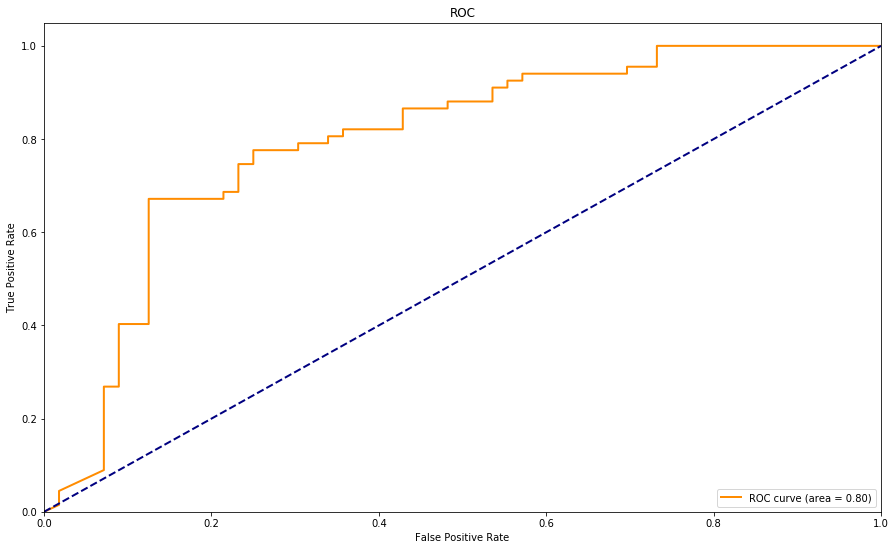

In [157]:
plt.figure(figsize=(15, 9))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()